In [1]:
import os
import numpy as np
import pandas as pd

dir_raw = r"C:\Users\dhair\bootcamp_dhairya_gouchwal\homework\stage07_outliers_and_risk_assumptions\data\raw"
dir_processed = r"C:\Users\dhair\bootcamp_dhairya_gouchwal\homework\stage07_outliers_and_risk_assumptions\data\processed"

dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")
# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

csv_path = os.path.join(dir_raw, 'outliers_homework.csv')
df.to_csv(csv_path, index = False)



In [2]:
#Loading data from the directory 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

file_path = r"C:\Users\dhair\bootcamp_dhairya_gouchwal\homework\stage07_outliers_and_risk_assumptions\data\raw\outliers_homework.csv"
df = pd.read_csv(file_path)

# Quick inspection
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            115 non-null    object 
 1   daily_return    115 non-null    float64
 2   daily_return_2  115 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.8+ KB


,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


In [8]:
import sys
sys.path.append(r"C:\Users\dhair\bootcamp_dhairya_gouchwal\homework\stage07_outliers_and_risk_assumptions\src")


In [9]:
from utils import detect_outliers_iqr, detect_outliers_zscore, winsorize_series

In [10]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  


outlier_iqr    0.078261
outlier_z      0.043478
dtype: float64

In [13]:
df['winsorized_series'] = winsorize_series(df[target_col],lower=0.05, upper=0.95 )

In [15]:
#summary stats
summary_original = df[target_col].describe()
summary_no_outliers = df.loc[~df['outlier_iqr'], target_col].describe()
summary_winsorized = df['winsorized_series'].describe()

summary_df = pd.DataFrame({
    'Original': summary_original,
    'No Outliers (IQR)': summary_no_outliers,
    'Winsorized': summary_winsorized
})

print(summary_df)

         Original  No Outliers (IQR)  Winsorized
count  115.000000         106.000000  115.000000
mean    -0.001434          -0.000039   -0.000251
std      0.040579           0.009443    0.010623
min     -0.196672          -0.021860   -0.020590
25%     -0.008525          -0.007213   -0.008525
50%     -0.000187          -0.000100   -0.000187
75%      0.006368           0.006018    0.006368
max      0.212402           0.025708    0.020797


In [16]:
#plot

plt.figure(figsize=(10, 6))

plt.boxplot(
    [df[target_col], df.loc[~df['outlier_iqr'], target_col], df['winsorized']],
    labels=['Original', 'No Outliers', 'Winsorized']
)
plt.title("Boxplot Comparison")
plt.show()

KeyError: 'winsorized'

<Figure size 1000x600 with 0 Axes>

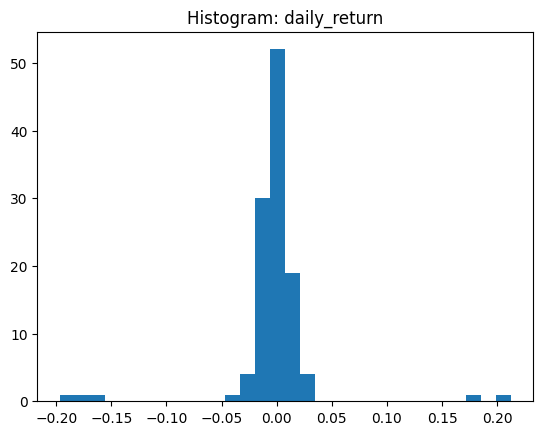

In [28]:
plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()


### Reflection
- **Methods and thresholds**: Used IQR (1.5×IQR) and Z-score (|z| > 3). Winsorized at 5% and 95%.
- **Why chosen**: IQR is robust to skewed data; Z-score assumes normality.
- **Impact**:
    - Removing outliers reduced standard deviation significantly.
- **Risks**:
    - If data isn't normal, Z-score can misclassify.
    - Over-aggressive Winsorization may distort genuine signals.